# Battle of the Neighbourhoods - Holiday Destinations

![Sandcastle](Capture.JPG)

## Project Description:

While this was supposed to be a project to compare two neighbourhoods, I decided that in my life it would be more useful to try to analyse and understand which holiday would suit us the best.

### Description of the problem:

Last year when we went on holiday to Devon for the 4th year running, we went to the beach and my wife, who's never that enthusiastic about beach trips, came along with us. We built our sand castle while Mrs D sat down and started to read her book. 
As the wind was blowing and we'd bought a kite, we boys went off and flew it and were off across the beach having fun. When we got back we couldn't find Mrs D but there was the remains of our sand castle :( 
Mrs D turned up soaking wet and explained that the tide had come in and caught her completely unawares and that she and her soggy book were going back to the holiday cottage right now.
So all future holidays, she says, will be city breaks.
### Analysis Saves the day (hopefully)

This project will search potential holiday destinations and score them for desirability based on the requirements of all of the family. I will be searching for the top 100 attractions from centroid location in a city and assigning each a score. 
This will give a better understanding of what is on offer within walking distance of each centre and enable me to make a case ~~that there really isn't anything there for children and that we should go to the sea-side instead~~ for a fairer choice of holiday destination

## Methodology

First we'll identify 3 holiday destination coordinates using Geopy and our original tried and tested holiday destination, Devon, for comparison purposes:

In [90]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import warnings
warnings.filterwarnings('ignore')
address = 'Exeter, Devon'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of {} is {}, {}.'.format(address, latitude_x, longitude_y))

The geograpical coordinate of Exeter, Devon is 50.725562, -3.5269108.


and plot them on a map to visually detail the scope:

In [190]:
import folium

In [297]:
m = folium.Map(
    location=[52.3745403, 4.89797550561798],
    zoom_start=5,
    tiles='Stamen Terrain'
)

folium.Marker(
    location=[55.6867243, 12.5700724],
    popup='Copenhagen',
    icon=folium.Icon(icon='flag')
).add_to(m)

folium.Marker(
    location=[48.85341, 2.3488],
    popup='Paris',
    icon=folium.Icon(color='green', icon='flag')
).add_to(m)

folium.Marker(
    location=[52.6843696, -1.8275286],
    popup='Home',
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

folium.Marker(
    location=[52.3745403, 4.89797550561798],
    popup='Amsterdam',
    icon=folium.Icon(color='orange', icon='flag')
).add_to(m)

folium.Marker(
    location=[50.725562, -3.5269108],
    popup='Devon',
    icon=folium.Icon(color='red', icon='heart')
).add_to(m)

![Europe](Europe.JPG)

## Next steps

I'm next going to use these coordinates in a Foursquare query to find venues, hopefully restricted to holiday attractions, though I haven't figured that out yet, and display these with appropriate markers onto a map.

Then determine scores for each of these categories for the 4 members of the family (M, A, Z and E) and put these into a DataFrame

Combining the data from FourSquare and the scores from the family, calculate the desirability of the 4 holiday destinations: Devon (control), Paris, Copenhagen and Amsterdam.

Then use clusting analysis to ensure that each member of the family will enjoy the holiday and prepare a presentation back to Mrs D to get her buy in on the decision made.

### Let's get organised

In [6]:
Copenhagen_Coords =[55.6867243, 12.5700724]
Paris_Coords=[48.85341, 2.3488]
Amsterdam_Coords=[52.3745403, 4.89797550561798]
Devon_Coords=[50.725562, -3.5269108]

Import the libraries we're going to need:

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib as plt
import matplotlib.colors as colors

In [194]:
# FourSquare Credentials
CLIENT_ID = 'MGCWI2D02FDUZHI33VCHJQNT5ZCQP5WAEC0LIONYVUS2PZHV' 
CLIENT_SECRET = '32J1QAJXVVUSSAAQATHLRJTT35HCZMDBNQXUPJQSW12BHYVO'
VERSION = '20180605'

## First challenge - Filtering FourSquare results so that it only brings back results that are relevant
This was easier than I thought it would be! 

https://developer.foursquare.com/docs/api/venues/recommendations
: 
By setting the 'intent' filter, we can only bring back venues of that category: food, breakfast, brunch, lunch, coffee, dinner, dessert, drinks, shopping, fun, sights. Specifies the top-level “intent” for a search.

For my holiday activities, I'm going to use 'fun'

In [195]:
intent = 'fun'
radius = 2000
LIMIT = 100

First we'll define a function to clean up the data received from FourSquare

In [196]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Then I've written a cool function to return the required data given a set of coordinates:

In [197]:
def get_holiday_fun(coords):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, coords[0], coords[1], radius, LIMIT,intent)
    results = requests.get(url).json()
    venues=results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    return nearby_venues

I'll use my function 4 times to pull the information about 'fun' attractions in the potential holiday destinations

In [198]:
copenhagen_venues = get_holiday_fun(Copenhagen_Coords)
paris_venues = get_holiday_fun(Paris_Coords)
amsterdam_venues = get_holiday_fun(Amsterdam_Coords)
devon_venues = get_holiday_fun(Devon_Coords)

I now need a distinct list of attractions so that I can take these to my audience and ask them which is most important for our holiday. So I combine the datasets into one after having marked each with the city names:

In [199]:
# Combine Datasets
copenhagen_venues['City'] = 'Copenhagen'
paris_venues['City'] = 'Paris'
amsterdam_venues['City'] = 'Amsterdam'
devon_venues['City'] = 'Devon'
df = pd.concat([copenhagen_venues, paris_venues,amsterdam_venues,devon_venues])
df.columns = ['Name','Categories','Latitude','Longitude','City']

Using the .unique() function, I've found each type of attraction and written this to a CSV

In [200]:
categories = df.Categories.unique()

dataset = pd.DataFrame({'Categories':categories})

dataset.sort_values(by=['Categories'], ascending = True).to_csv(r'categories.csv')

Having spoken to the family and decided what the best things to do on holiday are, I've loaded the data back into a dataframe:

In [259]:
scoring = pd.DataFrame(pd.read_csv("category_scores.csv").to_dict(orient="row"))

scoring.head()

,Categories,Score
0,Science Museum,10
1,Theme Park,10
2,Theme Park Ride / Attraction,10
3,Zoo,10
4,Zoo Exhibit,10


Next I need to join the scores to my dataframe with all the attractions:

In [260]:
df.head()

,Name,Categories,Latitude,Longitude,City
0,Rosenborg Slot,Palace,55.685683,12.577482,Copenhagen
1,Statens Museum for Kunst - SMK,Art Museum,55.688575,12.578399,Copenhagen
2,Kongens Have,Park,55.684361,12.580099,Copenhagen
3,Ørstedsparken,Park,55.680670,12.566367,Copenhagen
4,Cinemateket,Indie Movie Theater,55.683182,12.578596,Copenhagen


In [261]:
df2 = pd.merge(df, scoring, how='left', on=['Categories','Categories'])

df2.head()

,Name,Categories,Latitude,Longitude,City,Score
0,Rosenborg Slot,Palace,55.685683,12.577482,Copenhagen,7
1,Statens Museum for Kunst - SMK,Art Museum,55.688575,12.578399,Copenhagen,2
2,Kongens Have,Park,55.684361,12.580099,Copenhagen,9
3,Ørstedsparken,Park,55.680670,12.566367,Copenhagen,9
4,Cinemateket,Indie Movie Theater,55.683182,12.578596,Copenhagen,3


So now every venue has a score out of ten to indicate it's desirability

In [262]:
df2.groupby('City')['City'].value_counts()

City        City      
Amsterdam   Amsterdam     100
Copenhagen  Copenhagen    100
Devon       Devon          25
Paris       Paris         100
Name: City, dtype: int64

In [263]:
df2.groupby('City')['Score'].mean()

City
Amsterdam     5.15
Copenhagen    5.11
Devon         5.52
Paris         4.50
Name: Score, dtype: float64

# Conclusion 1: Devon scores highest on average venue score!


Next we'll draw some charts to illustrate the relative merits of each holiday destination

In [252]:
import matplotlib.pyplot as plt

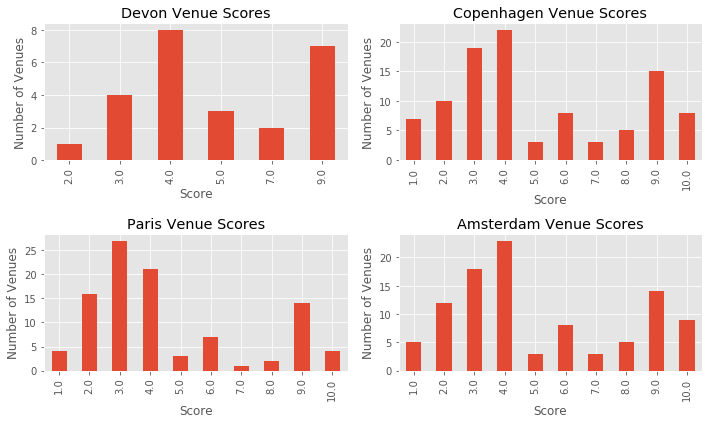

In [253]:
plt.subplot(2,2,1)

Devon_rows = df2['City'] == 'Devon'
Devon_venues = df2[Devon_rows]
Devon_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Devon Venue Scores') # add title to the plot

plt.subplot(2,2,2)

Copenhagen_rows = df2['City'] == 'Copenhagen'
Copenhagen_venues = df2[Copenhagen_rows]
Copenhagen_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Copenhagen Venue Scores') # add title to the plot

plt.subplot(2,2,3)

Paris_rows = df2['City'] == 'Paris'
Paris_venues = df2[Paris_rows]
Paris_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Paris Venue Scores') # add title to the plot

plt.subplot(2,2,4)

Amsterdam_rows = df2['City'] == 'Amsterdam'
Amsterdam_venues = df2[Amsterdam_rows]
Amsterdam_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Amsterdam Venue Scores') # add title to the plot


plt.tight_layout()
plt.show()

What I've liked about Python is the ease that you can switch this to a pie chart array instead, simply by changing kind='bar' to kind='pie'

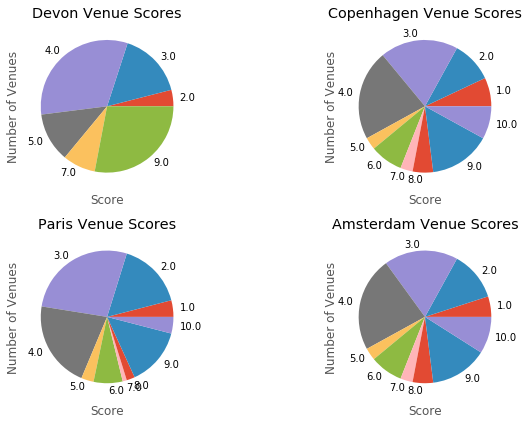

In [254]:
plt.subplot(2,2,1)

Devon_rows = df2['City'] == 'Devon'
Devon_venues = df2[Devon_rows]
Devon_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Devon Venue Scores') # add title to the plot

plt.subplot(2,2,2)

Copenhagen_rows = df2['City'] == 'Copenhagen'
Copenhagen_venues = df2[Copenhagen_rows]
Copenhagen_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Copenhagen Venue Scores') # add title to the plot

plt.subplot(2,2,3)

Paris_rows = df2['City'] == 'Paris'
Paris_venues = df2[Paris_rows]
Paris_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Paris Venue Scores') # add title to the plot

plt.subplot(2,2,4)

Amsterdam_rows = df2['City'] == 'Amsterdam'
Amsterdam_venues = df2[Amsterdam_rows]
Amsterdam_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Amsterdam Venue Scores') # add title to the plot


plt.tight_layout()
plt.show()

Next let's plot each of the destination venues onto a map and colourcode each by desirability

In [272]:
colour = ['white','grey','lightblue','lightblue','blue','orange','orange','green','green','green','green']

In [273]:
devon = folium.Map(
    location=Devon_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

copenhagen = folium.Map(
    location=Copenhagen_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

paris = folium.Map(
    location=Paris_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

amsterdam = folium.Map(
    location=Amsterdam_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

In [274]:
def plot_venue(city,latitude,longitude,category,color):
    folium.Marker(location=[latitude, longitude],popup=category,icon=folium.Icon(color=color, icon='flag')
                ).add_to(city)

In [275]:
for index, row in df2.iterrows():
    if (row['City'] == 'Devon'):
        plot_venue(devon,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])
        
for index, row in df2.iterrows():
    if (row['City'] == 'Copenhagen'):
        plot_venue(copenhagen,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])

for index, row in df2.iterrows():
    if (row['City'] == 'Paris'):
        plot_venue(paris,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])
       
for index, row in df2.iterrows():
    if (row['City'] == 'Amsterdam'):
        plot_venue(amsterdam,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])

# Devon

![Devon](Devon.jpg)

# Copenhagen

![Copenhagen](Copenhagen.jpg)

# Paris

![Paris](Paris.jpg)

# Amsterdam

![Amsterdam](Amsterdam .jpg)

Finally, let's do some onehot encoding to find the most common venues in each city

In [287]:
# one hot encoding
df_onehot = pd.get_dummies(df2[['Categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['City'] = df2['City']

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_grouped = df_onehot.groupby('City').mean().reset_index()
df_grouped

,City,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Bar,Boat or Ferry,Bookstore,Bowling Alley,...,Science Museum,Soccer Stadium,Stadium,Tattoo Parlor,Theater,Theme Park,Theme Park Ride / Attraction,University,Zoo,Zoo Exhibit
0,Amsterdam,0.00,0.03,0.09,0.07,0.00,0.04,0.01,0.00,0.00,...,0.03,0.00,0.00,0.01,0.07,0.00,0.03,0.00,0.01,0.02
1,Copenhagen,0.01,0.00,0.06,0.05,0.01,0.04,0.00,0.00,0.01,...,0.02,0.03,0.01,0.00,0.10,0.04,0.02,0.01,0.00,0.00
2,Devon,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.04,...,0.00,0.08,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00
3,Paris,0.00,0.00,0.17,0.08,0.00,0.00,0.00,0.01,0.00,...,0.03,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.01,0.00


In [290]:
num_top_venues = 5

for hood in df_grouped['City']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amsterdam----
           venue  freq
0         Museum  0.13
1    Art Gallery  0.09
2     Art Museum  0.07
3        Theater  0.07
4  Movie Theater  0.05


----Copenhagen----
         venue  freq
0         Park  0.13
1      Theater  0.10
2  Music Venue  0.07
3  Art Gallery  0.06
4   Art Museum  0.05


----Devon----
            venue  freq
0            Park  0.20
1  Soccer Stadium  0.08
2             Bar  0.08
3         Theater  0.08
4   Historic Site  0.08


----Paris----
                 venue  freq
0          Art Gallery  0.17
1        Historic Site  0.14
2  Indie Movie Theater  0.09
3           Art Museum  0.08
4                 Park  0.07




# Conclusions

Using the above analysis, I have discovered that all of the cities I've chosen do answer to some of our holiday requirements. Devon, naturally come out top on average score and this was highlighted by the high frequencies of parks - which are a big favourite for our boys.

Copenhagen also scored highly in the same ways. Parks are very prevalent and it scores highly on average attration ratings.

So in conclusion, we're going to be planning a holiday to Copenhagen for 2019!

# Afterthoughts

One of the key parts of delivering any analysis to stakeholders is to KNOW YOUR AUDIENCE. I could have spent a lot of time building kMeans models and sourcing additional data to support my analysis but given that my wife and children are as far from a technical audience as you can get, there seemed little point.

This is probably true for the analysis which I am carrying out at work also. Simplicity is key.

I've focussed on visuals using Python's very user friendly mapping capabilities and plotted some simple charts